# Pre-Process Input Data for Landslide Susceptibility Analysis

## Package Import, Working Directory and Functions

In [1]:
# import packages
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
from pykrige.ok import OrdinaryKriging
from rasterio.enums import Resampling
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold


In [ ]:
# TODO: set working directory
work_dir = "/local/path/to/GEO403_landslide_susceptibility_analysis"
os.chdir(work_dir)

In [3]:
def align_raster_to_reference(source_path, reference_path, output_path):
    """Align raster to reference raster.
    Args:
        source_path (str): Source path of raster
        reference_path (str): Source path of reference raster
        output_path (str): Output path of aligned raster
    """
    # open reference raster
    with rio.open(reference_path) as ref:
        ref_transform = ref.transform
        ref_crs = ref.crs
        ref_width = ref.width
        ref_height = ref.height

        # open and align source raster
        with rio.open(source_path) as src:
            kwargs = ref.meta.copy()
            kwargs.update({
                'height': ref_height,
                'width': ref_width,
                'transform': ref_transform
            })
            # reproject and write aligned raster
            with rio.open(output_path, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rio.band(src, i),
                        destination=rio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=ref_transform,
                        dst_crs=ref_crs,
                        resampling=Resampling.nearest
                    )

## Create Precipitation Raster

### Load Precipitation Data into GeoDataFrame

In [4]:
# define precipitation shapefile path
prec_loc_path = "data/data/precipitation/precip_data.shp"

# read precipitatio shapfile into geodataframe
prec_gdf = gpd.read_file(prec_loc_path)

# print precipitation gdf header
print("Columns of precipitation GDF:")
print(prec_gdf.columns)

Columns of precipitation GDF:
Index(['Station', 'Lat_y', 'Long_x', 'elev', 'geometry'], dtype='object')


In [5]:
# define precipitation values path
prec_vals_path = "data/data/precipitation/precip_time_series.xlsx"

# read precipitation values into dataframe
prec_df = pd.read_excel(prec_vals_path, header=5)

In [6]:
# drop not needed columns
columns_to_drop = ["year", "79-2011 ohne 87", "month"]
prec_df = prec_df.drop(columns=[col for col in columns_to_drop if col in prec_df.columns])

# calculate yearly means
prec_yearly_sum = prec_df.groupby(prec_df["date"].dt.year).sum(numeric_only=True)

In [7]:
# set 0.0 to nan in prec_yearly_sum
prec_yearly_sum = prec_yearly_sum.replace(0.0, np.nan)

# calculate mean of yearly precipitation (two digits)
prec_mean = prec_yearly_sum.mean().round(2)
prec_mean = pd.DataFrame(prec_mean)
prec_mean.columns = ["mean_annual_precip_sum"]

# rename index to station
prec_mean.index.name = "Station"

# merge prec_mean with geometry from prec_gdf
prec_gdf_annual = prec_gdf.merge(prec_mean, left_on="Station", right_on="Station")

### Evaluate best Variogram Model for Ordinary Kriging of Precipitation

In [8]:
# define list of variogram models for kriging
kriging_methods = ["linear", "exponential", "spherical", "gaussian"]

# define negative infinite values
inf_rmse = float("inf")
inf_mae = float("inf")

# create dict to store error metrics
error_dict = {}

# try each variogram model and save RMSE and MAE
for method in kriging_methods:
    # set number of folds for cross validation
    n_folds = 5

    # create kfold object
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # create list to store errors for each fold
    rmse_list = []
    mae_list = []

    # loop through defined folds
    for train_index, test_index in kf.split(prec_gdf_annual):
        train_gdf = prec_gdf_annual.iloc[train_index]
        test_gdf = prec_gdf_annual.iloc[test_index]
        
        # extract training data
        x_train = train_gdf.geometry.x
        y_train = train_gdf.geometry.y
        z_train = train_gdf['mean_annual_precip_sum']
        
        # extract test data
        x_test = test_gdf.geometry.x
        y_test = test_gdf.geometry.y
        z_test = test_gdf['mean_annual_precip_sum']
        
        # initalize and train kriging model
        OK = OrdinaryKriging(x_train, y_train, z_train, variogram_model=method, verbose=False)
        
        # predict for test data points
        z_pred, _ = OK.execute("points", x_test, y_test)
        
        # calculate error metrics
        rmse = np.sqrt(mean_squared_error(z_test, z_pred))
        mae = mean_absolute_error(z_test, z_pred)
        
        # append errors to lists
        rmse_list.append(rmse)
        mae_list.append(mae)

    # write error metrics to dict
    error_dict[method] = [np.mean(rmse_list), np.mean(mae_list)]

    # evaluate lowest RMSE and MAE
    inf_rmse = float("inf")
    inf_rmse = float("inf")
    for key in error_dict.keys():
        if error_dict[key][0] < inf_rmse:
            best_rmse = key
            inf_rmse = error_dict[key][0]
        if error_dict[key][1] < inf_mae:
            best_mae = key
            inf_mae = error_dict[key][0]

# print best model according to error metrics
if best_rmse == best_mae:
    best_method = best_rmse
    print(f"Best variogram model: {best_rmse}")
    print(f"RMSE: {inf_rmse}")
    print(f"MAE: {inf_mae}")
else:
    error_sum = float("inf")
    for key in error_dict.keys():
        if sum(error_dict[key]) < error_sum:
            error_sum = sum(error_dict[key])
            best_method = key
    print(f"RMSE and MAE of best method are different. The best kriging method according to the sum of both errors is '{best_method}'.")
    print(f"RMSE: {error_dict[best_method][0]}")
    print(f"MAE:  {error_dict[best_method][1]}")

RMSE and MAE of best method are different. The best kriging method according to the sum of both errors is 'linear'.
RMSE: 327.01980006886095
MAE:  265.8200964646483


Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 7.198746671884933
Nugget: 3.3117702798971236e-17 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kr

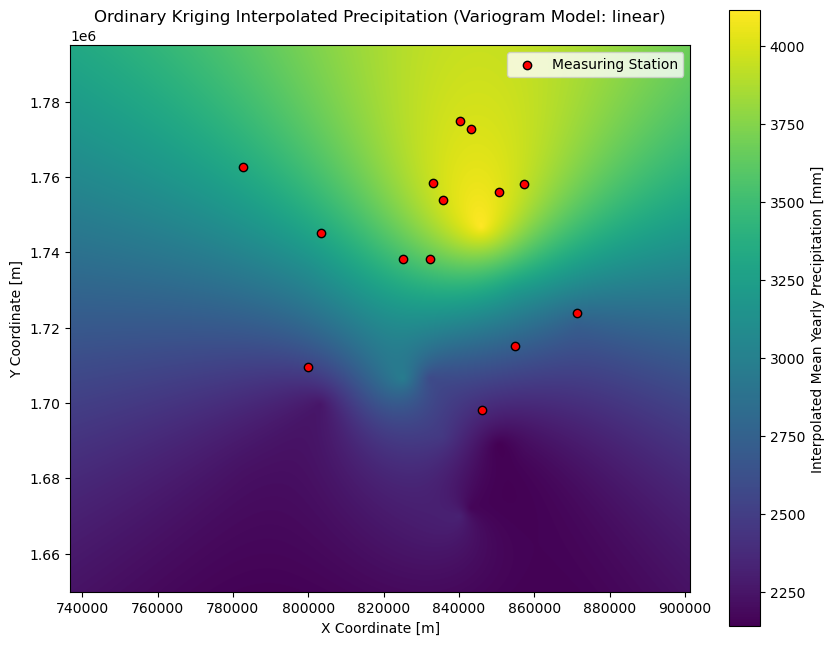

In [9]:
# TODO: decide if interpolated precipitation raster should be stored as file
save_prec_rast = True
prec_out_path = "created/aligned_rasters/precipitation.tif"

# define DEM raster path to use as reference
dem_path = 'created/dem.tif'

# set x, y, z values based on gdf
# make sure CRS is correct
prec_gdf_annual = prec_gdf_annual.to_crs(epsg=32648) 
x = prec_gdf_annual.geometry.x
y = prec_gdf_annual.geometry.y
z = prec_gdf_annual["mean_annual_precip_sum"]

# read DEM raster to get AOI bounds
with rio.open(dem_path) as dem_src:
    dem_bounds = dem_src.bounds
    xmin, ymin, xmax, ymax = dem_bounds.left, dem_bounds.bottom, dem_bounds.right, dem_bounds.top
    dem_resolution = dem_src.res[0]

# create raster with size of DEM raster
grid_x = np.arange(xmin, xmax, dem_resolution)
grid_y = np.arange(ymin, ymax, dem_resolution)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

# initialize kriging model with best performing variogram model
OK = OrdinaryKriging(
    x, y, z,
    variogram_model=best_method,
    verbose=True,
    enable_plotting=False
)

# interpolate and handle memory constraints with chunking
chunk_size = 500
prec_interp = np.zeros((len(grid_y), len(grid_x)), dtype=np.float32)
try:
    for i in range(0, len(grid_x), chunk_size):
        for j in range(0, len(grid_y), chunk_size):
            x_chunk = grid_x[i:i+chunk_size]
            y_chunk = grid_y[j:j+chunk_size]

            if len(x_chunk) > 0 and len(y_chunk) > 0:
                grid_chunk_xx, grid_chunk_yy = np.meshgrid(x_chunk, y_chunk)

                # execute kriging for current chunk
                chunk_result, ss = OK.execute(
                    "grid",
                    x_chunk,
                    y_chunk
                )

                # write the result back into the main array
                prec_interp[j:j+chunk_size, i:i+chunk_size] = chunk_result
except MemoryError:
    print("Memory Error: Decrease raster size or number of precipitation stations.")

# save interpolated precipitation raster if needed
if save_prec_rast:
    # transform for rasterio (top left, cell size)
    transform = from_origin(xmin, ymax, dem_resolution, dem_resolution)

    # write raster as GeoTIFF
    with rio.open(
        prec_out_path, "w",
        driver="GTiff",
        height=prec_interp.shape[0],
        width=prec_interp.shape[1],
        count=1,
        dtype=prec_interp.dtype,
        crs="EPSG:32648",
        transform=transform,
    ) as dst:
        dst.write(prec_interp, 1)
    
    print(f"Interpolated raster save in as <{prec_out_path}>")

# plot interpolated precipitation raster
plt.figure(figsize=(10, 8))
plt.imshow(prec_interp, extent=(xmin, xmax, ymin, ymax), origin="upper", cmap="viridis")
plt.colorbar(label="Interpolated Mean Yearly Precipitation [mm]")
plt.scatter(x, y, c="red", edgecolor="k", label="Measuring Station")
plt.legend()
plt.title(f"Ordinary Kriging Interpolated Precipitation (Variogram Model: {best_method})")
plt.xlabel("X Coordinate [m]")
plt.ylabel("Y Coordinate [m]")
plt.show()


## Align and Clip Input Rasters to DEM Raster

In [11]:
# define input raster paths
input_rasters = [
    'created/landcover.tif',
    'created/litho.tif',
    'created/soil.tif',
    'created/water_distance.tif',
    'created/road_distance.tif',
    'created/view.tif',
    'created/landslides.tif',
    'created/aspect.tif',
    'created/slope.tif'
]
reference_raster = 'created/dem.tif'
output_dir = 'created/aligned_rasters/'

# ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# align each input raster to reference raster
for raster in input_rasters:
    output_path = os.path.join(output_dir, os.path.basename(raster))
    align_raster_to_reference(raster, reference_raster, output_path)
    print(f"Aligned {raster} to reference DEM and saved at: {output_path}")


Aligned created/landcover.tif to reference DEM and saved at: created/aligned_rasters/landcover.tif
Aligned created/litho.tif to reference DEM and saved at: created/aligned_rasters/litho.tif
Aligned created/soil.tif to reference DEM and saved at: created/aligned_rasters/soil.tif
Aligned created/water_distance.tif to reference DEM and saved at: created/aligned_rasters/water_distance.tif
Aligned created/road_distance.tif to reference DEM and saved at: created/aligned_rasters/road_distance.tif
Aligned created/view.tif to reference DEM and saved at: created/aligned_rasters/view.tif
Aligned created/landslides.tif to reference DEM and saved at: created/aligned_rasters/landslides.tif
Aligned created/aspect.tif to reference DEM and saved at: created/aligned_rasters/aspect.tif
Aligned created/slope.tif to reference DEM and saved at: created/aligned_rasters/slope.tif


## Create Viewshed Mask

In [12]:
# define path to original viewshed and output path view mask
viewshed_path = "created/aligned_rasters/view.tif"
aligned_viewshed_bool_path = "created/aligned_rasters/view_mask.tif"

# load viewshed raster
with rio.open(viewshed_path) as src:
    viewshed_data = src.read(1)
    transform = src.transform
    crs = src.crs
    nodata = src.nodatavals[0]

    # create binary mask
    bool_mask = np.where(viewshed_data > 0, 1, 0).astype(np.uint8)

# save binary viewshed mask
with rio.open(
    aligned_viewshed_bool_path, "w",
    driver="GTiff",
    height=bool_mask.shape[0],
    width=bool_mask.shape[1],
    count=1,
    dtype=bool_mask.dtype,
    crs=crs,
    transform=transform,
    nodata=0
) as dst:
    dst.write(bool_mask, 1)

print(f"Viewshed mask saved at: <{aligned_viewshed_bool_path}>")


Viewshed mask saved at: <created/aligned_rasters/view_mask.tif>
